![](https://openweathermap.org/themes/openweathermap/assets/img/new-history-forecast-bulk.png)
# <center> Visual analysis of live weather data </center>
## <center> Interactive weather exploration tool for visual analysis on examples of central area of Ukraine and Eastern Africa </center>
**<div align=right>Made by</div>**
**<div align=right>Ihor Markevych</div>**

## <center> Objective </center>

**Create interactive visual representation tool for current weather data.**  
Provide easily readable information about 
- relief, 
- temperature over various points, 
- whether sky is clear / there is rain/storm,
- wind direction and speed.
  
To do so, create two charts:
- 2D chart that should contain information about relief and wind;
- 3D interactive chart that should represent relief, temperature, sky clearance.

Use cubic splines for creating continuous surface for easier readability.   
  
Create technical report on created tool.  
Based on created plots provide example of basic report over obtained data and recommendations on current weather activites.  
Provide technical recommendations of tool usage.

In [1]:
elevKey = '-u2t9Ek42w4bC4C-a2acWtk2NQ2han'
weatherKey = 'bfbb8bf45637787ff00f5fa7f5639f53'

In [2]:
from requests import get
import json
from gzip import decompress
from PIL import Image
import requests
from io import BytesIO
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.cm as cmx

In [4]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib import offsetbox

In [5]:
%matplotlib qt

## Functions:

#### Plot icons over 3D surface:

In [6]:
class ImageAnnotations3D():
    def __init__(self, xyz, images, ax3d, ax2d):
        self.xyz = xyz
        self.images = images
        self.ax3d = ax3d
        self.ax2d = ax2d
        self.annot = []
        for s, im in zip(self.xyz, images):
            x,y = self.proj(s)
            self.annot.append(self.image(im, [x, y]))
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect("draw_event", self.update)

        self.funcmap = {"button_press_event" : self.ax3d._button_press,
                        "motion_notify_event" : self.ax3d._on_move,
                        "button_release_event" : self.ax3d._button_release}

        self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb) \
                        for kind in self.funcmap.keys()]

    def cb(self, event):
        event.inaxes = self.ax3d
        self.funcmap[event.name](event)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x,y,z = X
        x2, y2, _ = proj3d.proj_transform(x,y,z, self.ax3d.get_proj())
        tr = self.ax3d.transData.transform((x2, y2))
        return self.ax2d.transData.inverted().transform(tr)

    def image(self,arr,xy):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr, zoom=0.3)
        im.image.axes = ax
        ab = offsetbox.AnnotationBbox(im, xy,
                            xycoords='data', boxcoords="offset points",
                            pad=0, frameon=False)
        self.ax2d.add_artist(ab)
        return ab

    def update(self,event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                        np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s,ab in zip(self.xyz, self.annot):
                ab.xy = self.proj(s)

#### Dowload image from URL:

In [7]:
def getImageFromUrl(url):
    response = get(url)
    img = Image.open(BytesIO(response.content))
    return img

#### Makes background of picture with icon transparent:

In [8]:
def makeBackgroundTransparent(img):
    planeImg = img
    data = planeImg.getdata()
    newData = []
    myAlpha = 150
    # loop through pixels in planeImg
    for item in data:
        # item[3] is the current pixel alpha value. When 0: transparent area on png, leave it at 0
        # item[{0, 1, 2}] is pixel {R,G,B} value
        if item[:-1] == (255,255,255) or item[3] == 0:
            newData.append((item[0], item[1], item[2], 0))
        # else the current pixel is a part of the plane: set alpha to desired value
        else:
            newData.append(item)
    planeImg.putdata(newData)
    return planeImg

#### Try-catch wrapping for obtaining wind direction (can be absent):

In [9]:
def getWind(w):
    try:
        res = w['deg']
    except:
        res = 0
    return res

## Mining

Obtain information about cities in the selected by latitude and longitude area.

In [10]:
cityListLink = 'http://bulk.openweathermap.org/sample/city.list.json.gz'
cityLists = json.loads(decompress(get(cityListLink).content))

(Mines information about Eastern Africa, commented, as results were saved and will be inserted separatly in "Results" section).

In [11]:
# cities = list(filter(lambda x: x['coord']['lon'] < 15 
#             and x['coord']['lon'] > 0 
#             and x['coord']['lat'] < 35 
#             and x['coord']['lat'] > 15, cityLists))
# len(cities)

Gather information about meteo-points around Kyiv and see length of obtained data.

In [12]:
cities = list(filter(lambda x: x['coord']['lon'] < 35
            and x['coord']['lon'] > 30
            and x['coord']['lat'] < 51 
            and x['coord']['lat'] > 50, cityLists))
len(cities)

107

Example of obtained information:

In [13]:
cities[0]

{'id': 711349,
 'name': 'Bucha',
 'country': 'UA',
 'coord': {'lon': 30.366671, 'lat': 50.583328}}

Based on https://openweathermap.org/current API and on https://elevation-api.io/ API mine next information about selected cities:
- latitude;
- longtitude;
- temperature;
- wind speed and direction;
- icon of weather (clear sky/rain/strom/snow etc.);

In [14]:
lat = []
lon = []
elev = []
temp = []
wind = []
icons = []
for x in cities:
    response = get('https://elevation-api.io/api/elevation?points=(' 
                   + str(x['coord']['lon']) 
                   + ',' 
                   + str(x['coord']['lat']) 
                   + ')&key=' + elevKey)
    w = json.loads(response.text)
    
    lat.append(w['elevations'][0]['lat'])
    lon.append(w['elevations'][0]['lon'])
    elev.append(w['elevations'][0]['elevation'])
    
    response = get('https://api.openweathermap.org/data/2.5/weather?id=' 
                   + str(x['id']) + '&APPID=' + weatherKey + '&units=metric')
    w = json.loads(response.text)
    temp.append(w['main']['temp'])
    icons.append(w['weather'][0]['icon']) # clouds, rain, sunny etc.
    wind.append(w['wind'])

Mine icons of weather:

In [15]:
imgs = [makeBackgroundTransparent(getImageFromUrl('http://openweathermap.org/img/wn/' + icon + '.png'))
        for icon in icons]

Prepare geo data, temperature data and data for plotting wind vectors.

In [16]:
speed = list(map(lambda x: x['speed'], wind))
degree = list(map(getWind, wind))

X = lat
Y = lon
Z = elev
C = temp
U = [deg * math.cos(math.radians(sp)) for deg, sp in zip(degree, speed)]
V = [deg * math.sin(math.radians(sp)) for deg, sp in zip(degree, speed)]

## Creation of visual representation

### Wind chart: contours and wind vectors

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)

xi = np.linspace(min(X), max(X), 100)
yi = np.linspace(min(Y), max(Y), 100)
xig, yig = np.meshgrid(xi, yi)

zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

col = griddata((X, Y), C, (xi[None,:], yi[:,None]), method='cubic')

CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')

plt.quiver(X, Y, U, V, pivot='middle')

C:\Users\Dergel\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'color'
  s)


### 3D chart: Geosurface and color-coded temperature

In [18]:
ax = fig.add_subplot(1, 2, 2, projection='3d')

surf = ax.plot_surface(xig, yig, zi, 
                       facecolors=cmx.coolwarm((col - np.nanmin(col))
                                               / (np.nanmax(col) - np.nanmin(col))),
                       linewidth=0)

C:\Users\Dergel\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


### 3D chart: scatter plot of meteo-stations

In [19]:
ax.scatter(X, Y, Z, s=40, c='red', marker="o")

### 3D chart: plot icons of sky condition

In [20]:
# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111,frame_on=False) 
ax2.axis("off")
ax2.axis([0,1,0,1])

ia = ImageAnnotations3D(np.c_[X,Y,Z], imgs, ax, ax2 )

plt.show()

## Findings

Note: created script builts interactive charts, but for quick overview of obtained results the following screenshots was provided:

### How to interpret:

**For left (2D) chart:**
- arrows represent wind direction and speed;
- contours in color represents relief;
  
**For right (3D) chart:**
- color represents temperature;
- red dots represents meteo-stations, from which data was gathered;
- color represents temperature (from warm (red) to cold (blue));
- icons represent sky condition;

### Kyiv

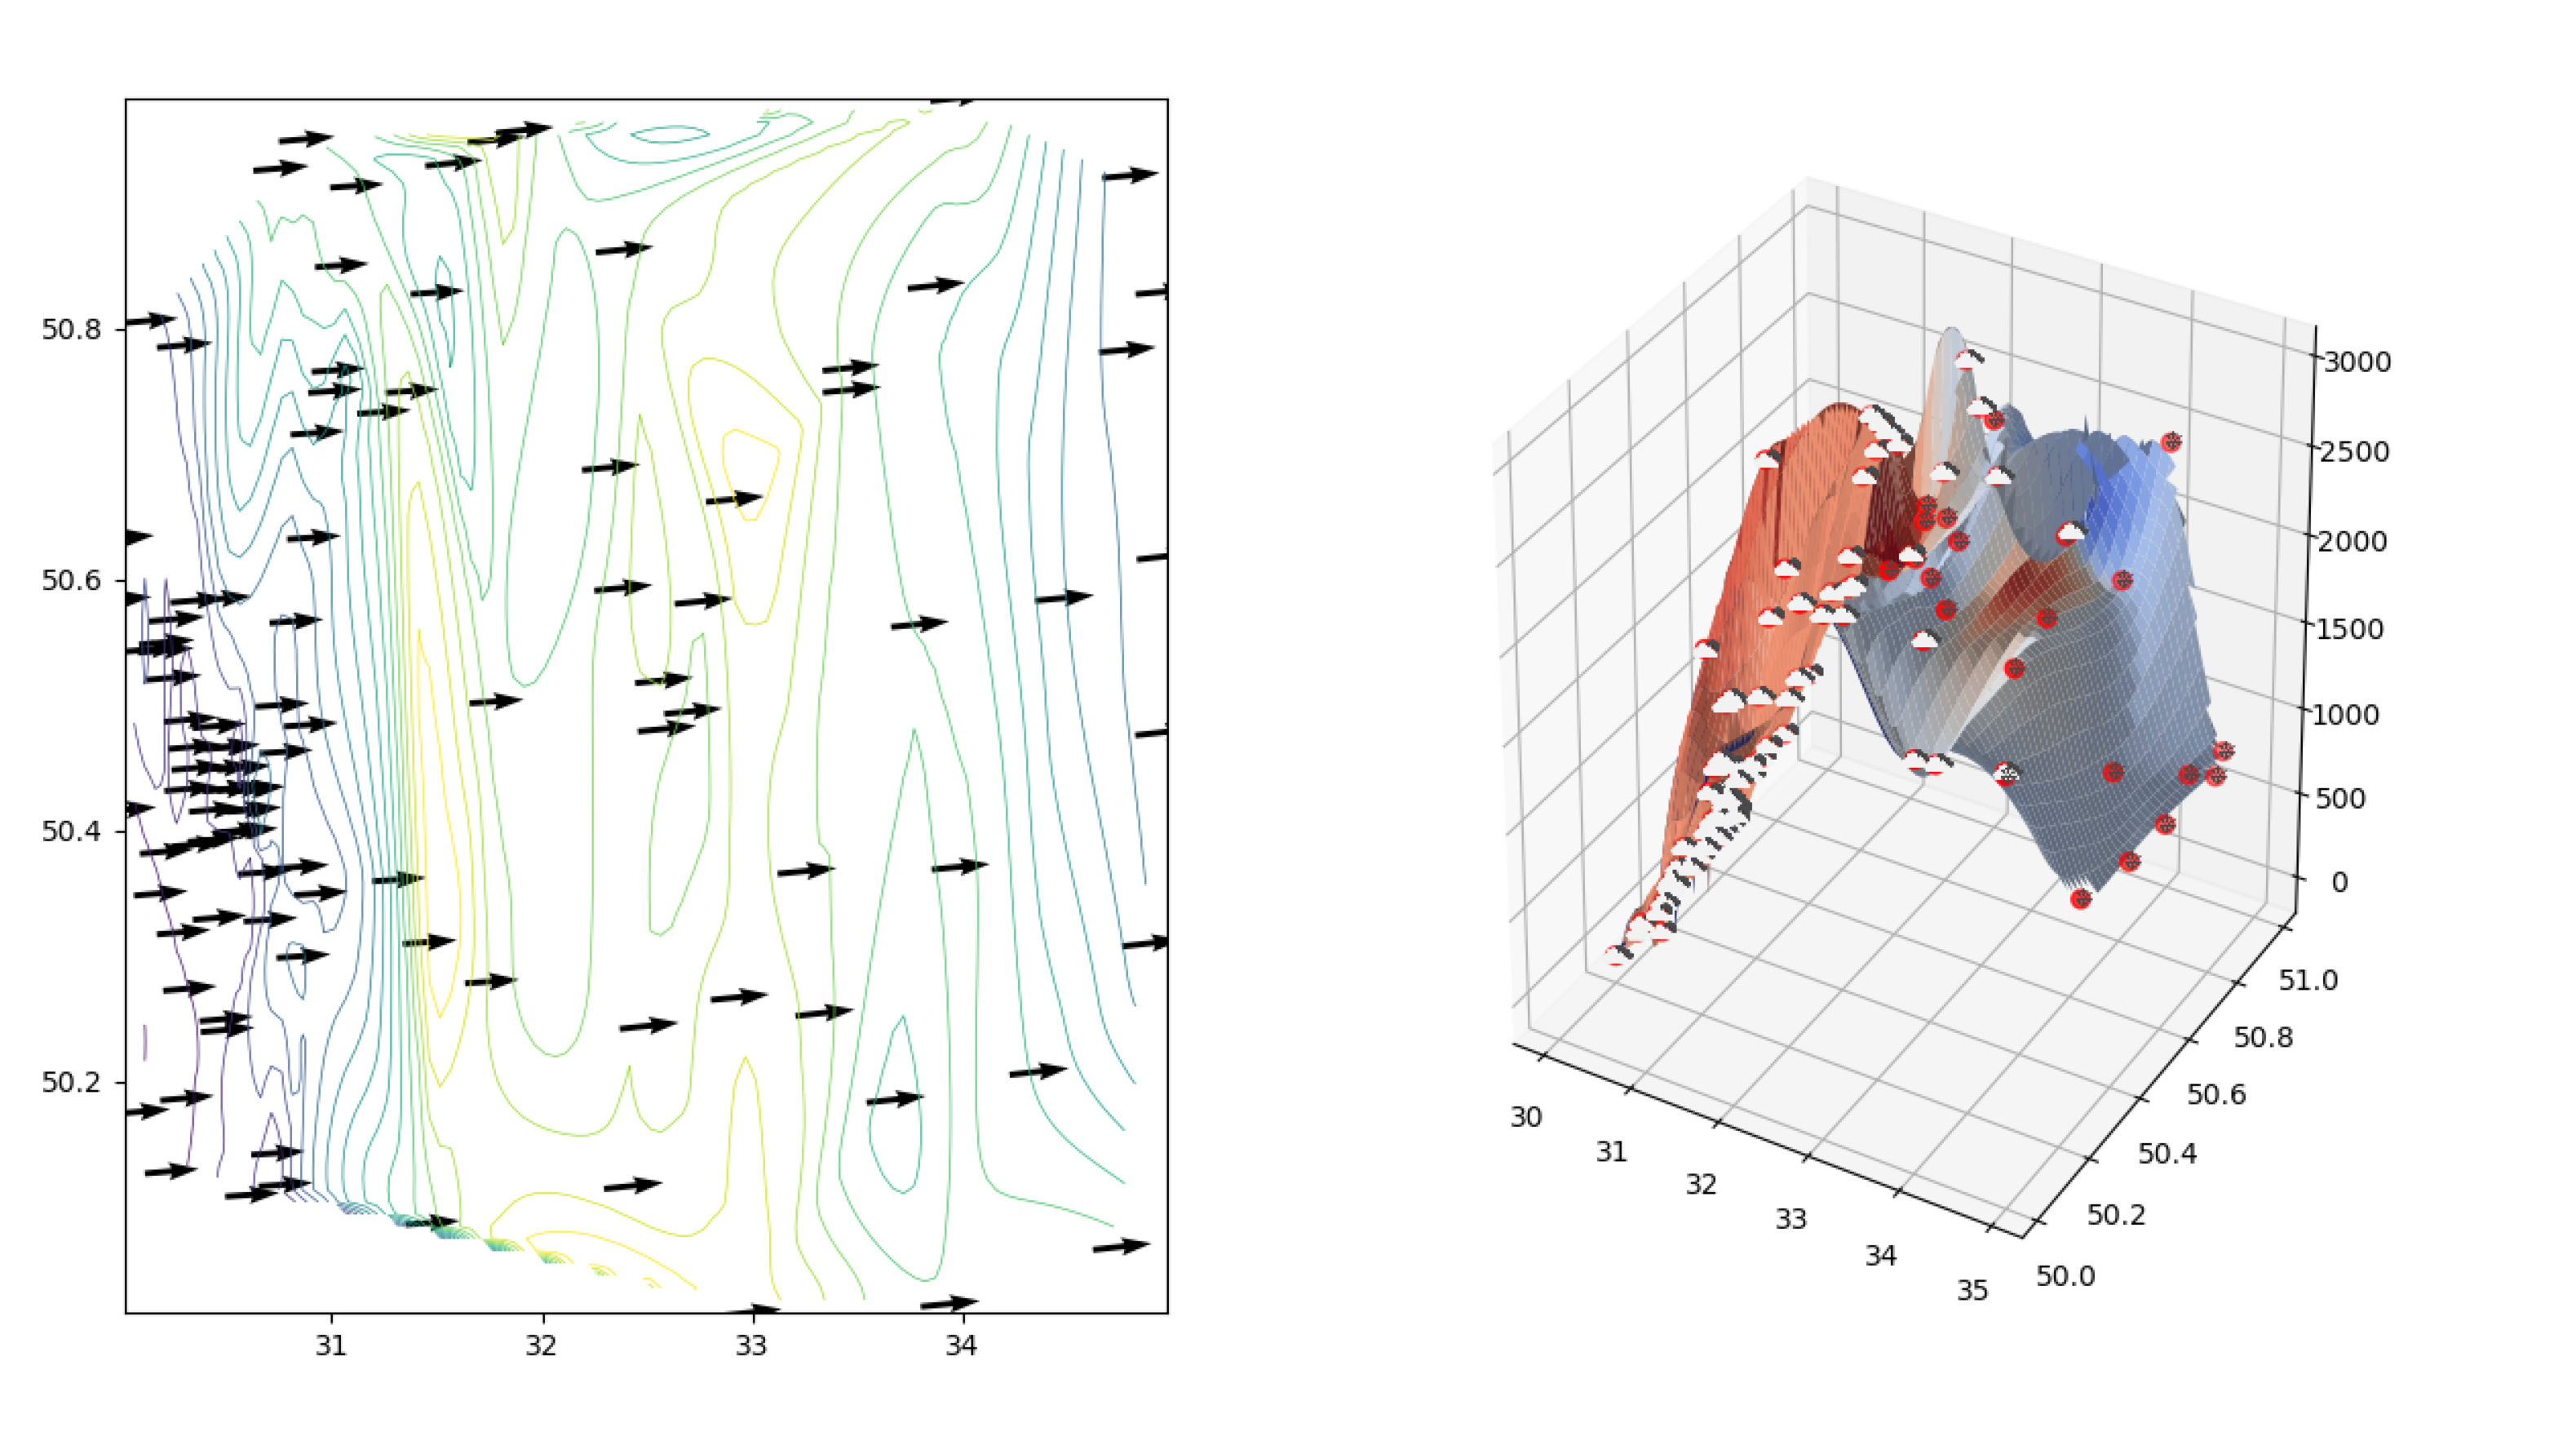

#### Comments

Strong difference between western and eastern parts of area around Kyiv can be seen. (Note: there is a river separating Kyiv and whole Ukraine in two parts).  
- Western part has clouded sky, while eastern part has snow.
- Western part has much warmer weather in comparison to eastern.

I can be also seen that much more data is available for western part of selected area than for eastern.  
  
In this particular case, conclusion about influence of river on local weather can be made - water masses together with height difference create two separate weather areas.  

#### Recommendations:

Additionally, for those who seeks warmer weather western part of area can be recommended for recreation.

### Eastern Africa
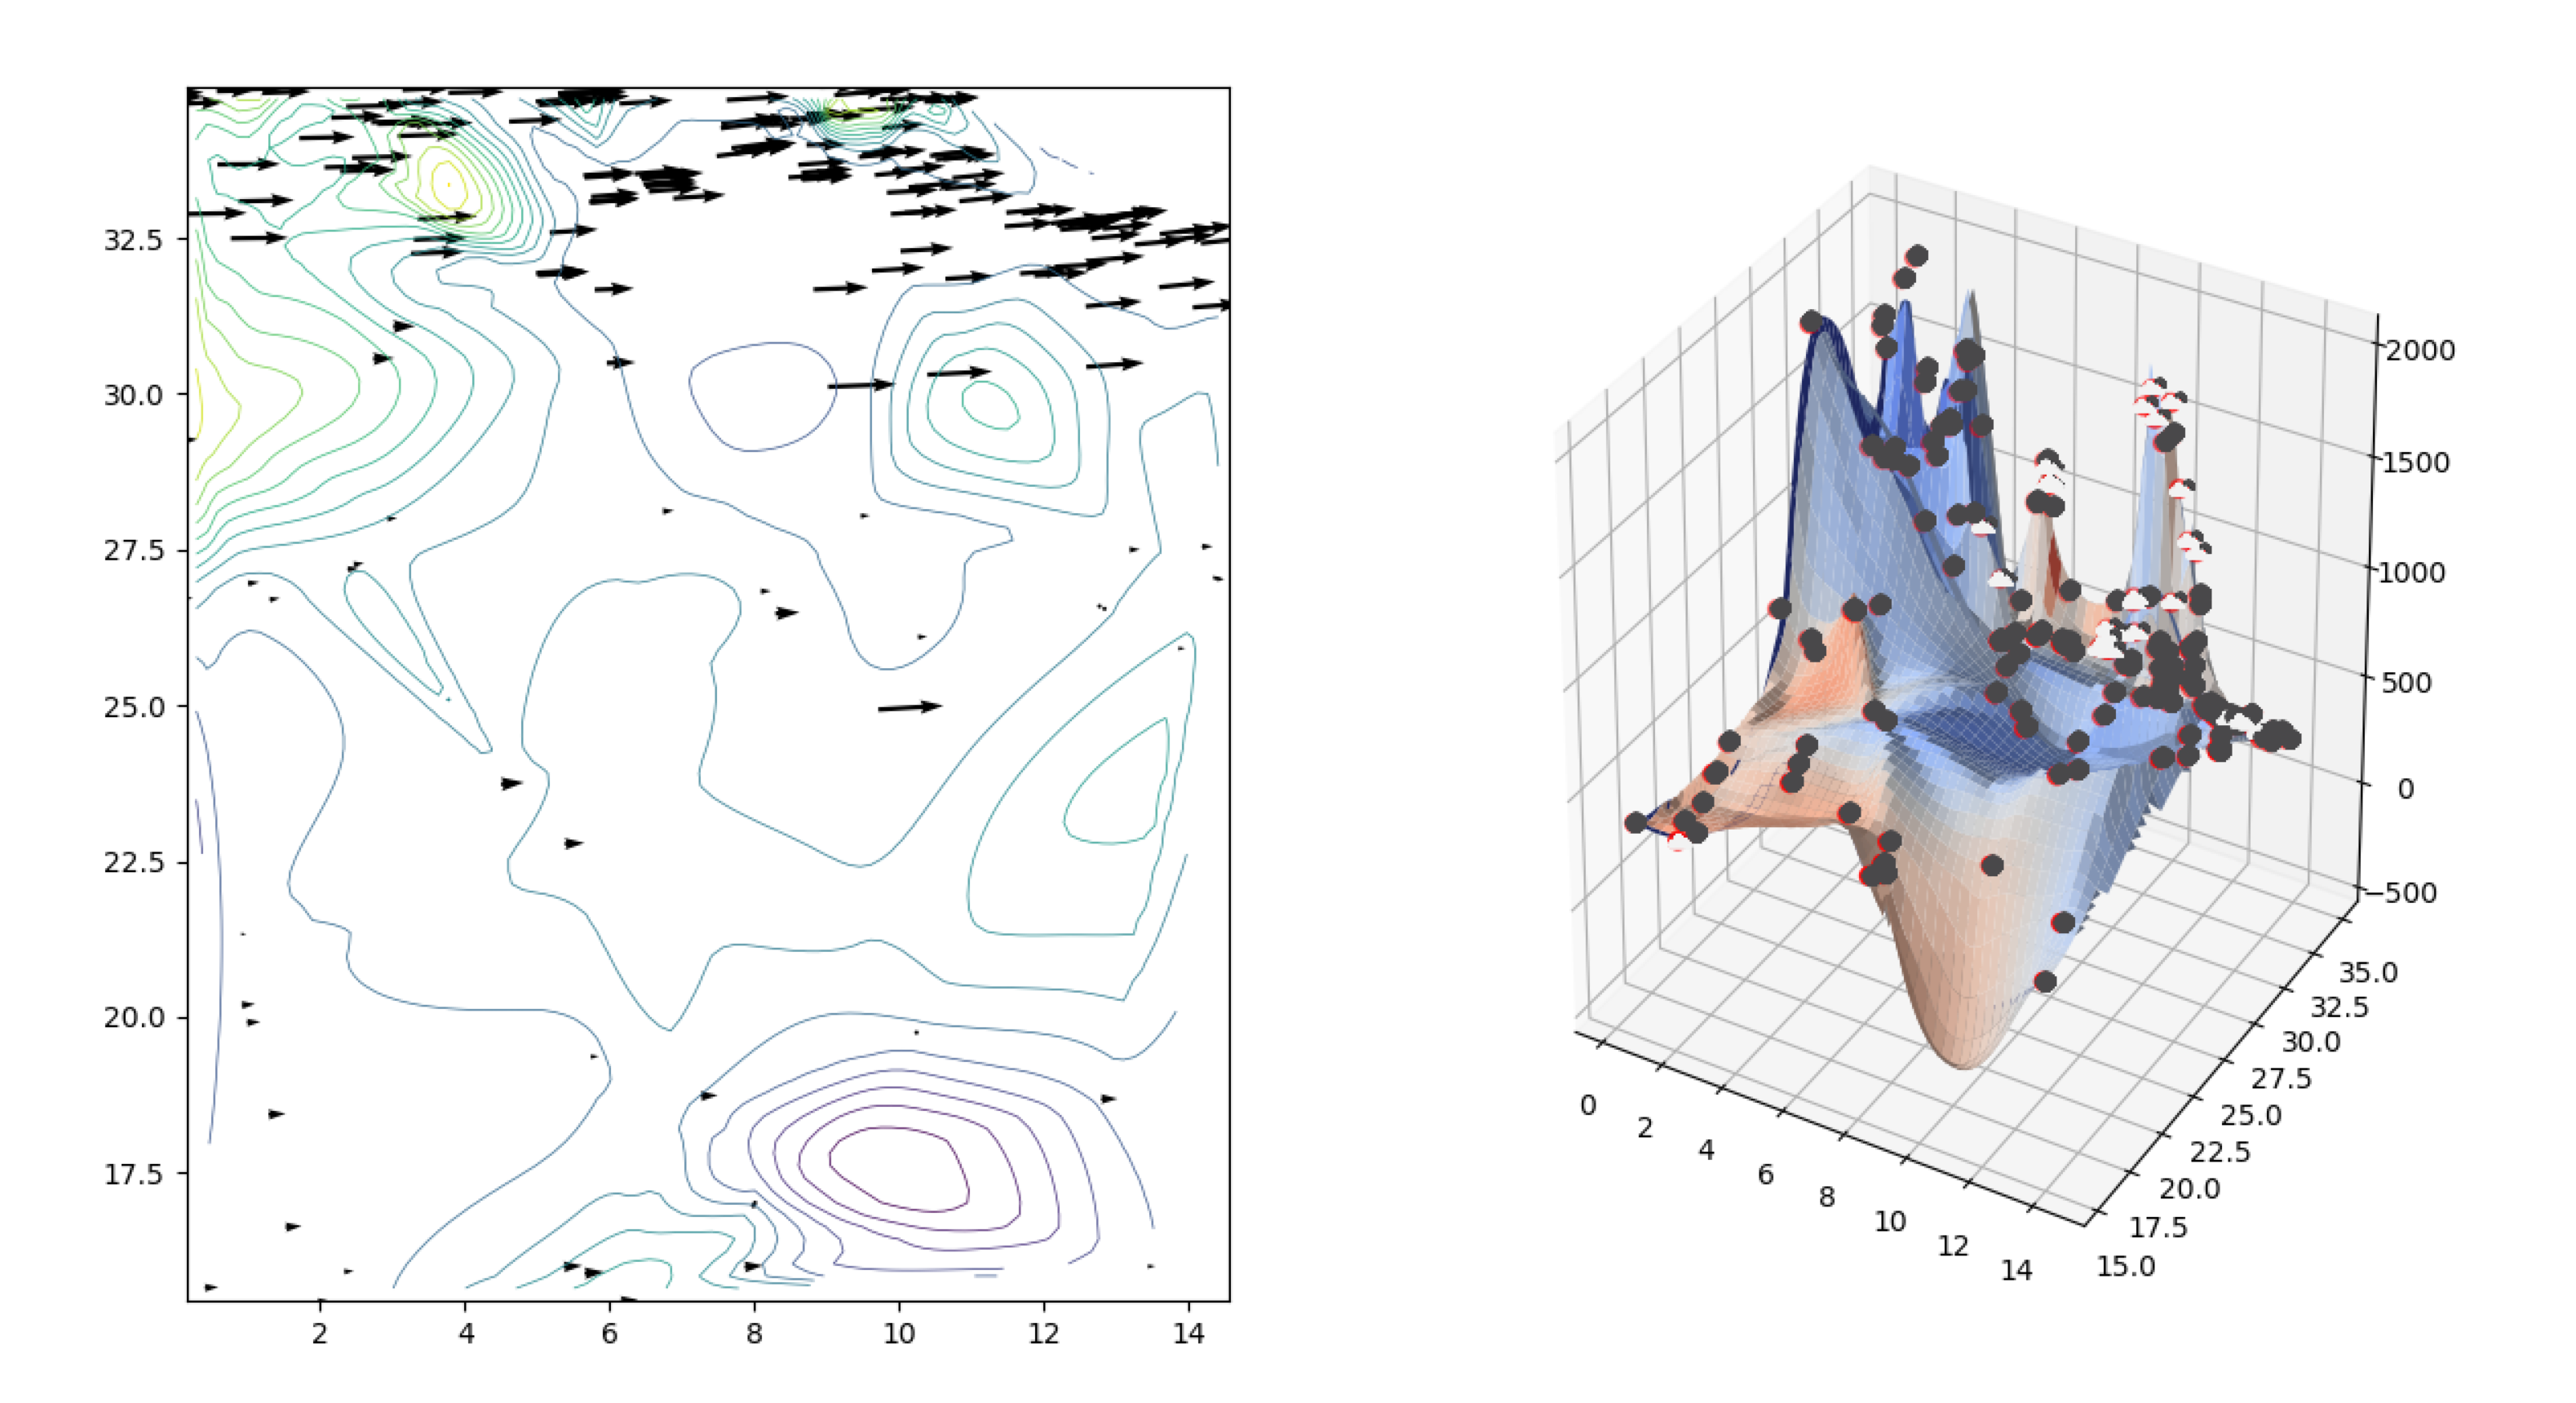

#### Comments

Terrain with significant height difference can be seen.  
  
Created tool gives the analyst the opportunity to see the flow of wind currents and understand that mountains are blocking the valley from both coldness and from winds.  
Such insights can either provide explanations to some weather model behaviours.

#### Recommendations

Following recommendation can be made: hikers should avoid north mountains of this area due to severe winds. In case of unpredicted critical situation rescue most likely will be significantly complicated by the fact of strong wind currents that may interrup helicopters flights.    

## Recommendations on tool usage:

Created tool can be used for either alone-standing weather analysis and reporting or for data exploration for particular problems. And example of such problem can be this [Flood prediction competition](https://zindi.africa/competitions/2030-vision-flood-prediction-in-malawi). With such tool potential confounding variables can be easily determined, for instance, for particular data elevation difference appeared to be highly correlated with target data.  
  
Before launching the tool area of interest should be deremined, as the more data will be included in the results, the less readable they be and significantly more time will be needed to generate report of data.  
Either country of geo-coordinates can be used to select needed cities. However, mining information for the whole country can be pretty computationly expensive due to densite of meteo reporting stations, therefore geo-coordinates are recommended for usage.
  
Separate note about wind analysis: wind speed and density of the meteo-reports should not be mixed. For instance, for Kyiv data, it may appear visually that wind currents are stronger on western part of chart, however, vector lengthes are around same, only density of ploted vectors is changed.

## References:
- https://scitools.org.uk/iris/docs/latest/examples/Meteorology/wind_speed.html
- https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
- https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points/53851017
- https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
- https://stackoverflow.com/questions/12730436/matplotlib-plotting-non-uniform-data-in-3d-surface
- https://stackoverflow.com/questions/51809017/add-transparent-picture-over-plot

## API used:
-  https://openweathermap.org/current
- https://elevation-api.io/ 